In [1]:
%run ./resources/library.py

# Notebook 3 - Drawing an Isochrone Map with OSMnx for Soho District in London (Part 1)

## Learning Objectives

By the end of this notebook, you should be able to:

1. Define an isochrone map
2. Recall the Python packages used in creating isochrone maps with osmnx
3. Describe the goal of map projections
4. Explain how an isochrone map helps identify which pump in Soho District appears to contribute to the cholera deaths based on walkability assumptions

## What is an Isochrone Map?

Isochrone maps are also known as travel time maps, from the Greek, "isos" (equal) + "khronos" (time). By drawing an isochrone map of Soho District based on the OSMnx street network graph, we can help Dr. John Snow visualize how far Soho District residents can walk given 1, 5, 10 or 15 minutes from the Broad Street Pump. 

In [2]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

# some configuration parameters for osmnx
# set log to True to for debugging

ox.config(
    log_console=True, 
    use_cache=True, 
    log_file=True,
    overpass_endpoint='https://overpass-api.de/api/interpreter',
    overpass_rate_limit=True,
    timeout=240
)

ox.__version__

'1.9.3'

We are using several Python packages for this notebook (the ones we have used are in <font color='red'>red</font>, links are provided for new ones):
1. <font color='red'>OSMnx</font>
2. <font color='red'>NetworkX</font>
3. <font color='red'>Pandas</font>
4. [GeoPandas](https://github.com/geopandas/geopandas)
5. <font color='red'>Matplotlib</font>
6. [Shapely](https://github.com/Toblerity/Shapely)
7. [Descartes](https://bitbucket.org/sgillies/descartes)

## Download and prep the street network

### Graph configuration variables

In [3]:
# configure the place, network type, trip times, and travel speed
BROAD_STREET_PUMP_COORDINATES = (51.513341, -0.136668)

network_type = 'walk'        # osmnx has different network types
trip_times = [1, 5, 10, 15]  # in minutes
travel_speed = 4.5           # assume walking speed in km/hour

Let's obtain the street network graph for Soho District based on the coordinates of the Broad Street Pump. To compute isochrones for the other pumps, you can use their coordinates in place of the Broad Street pump's in the code below.

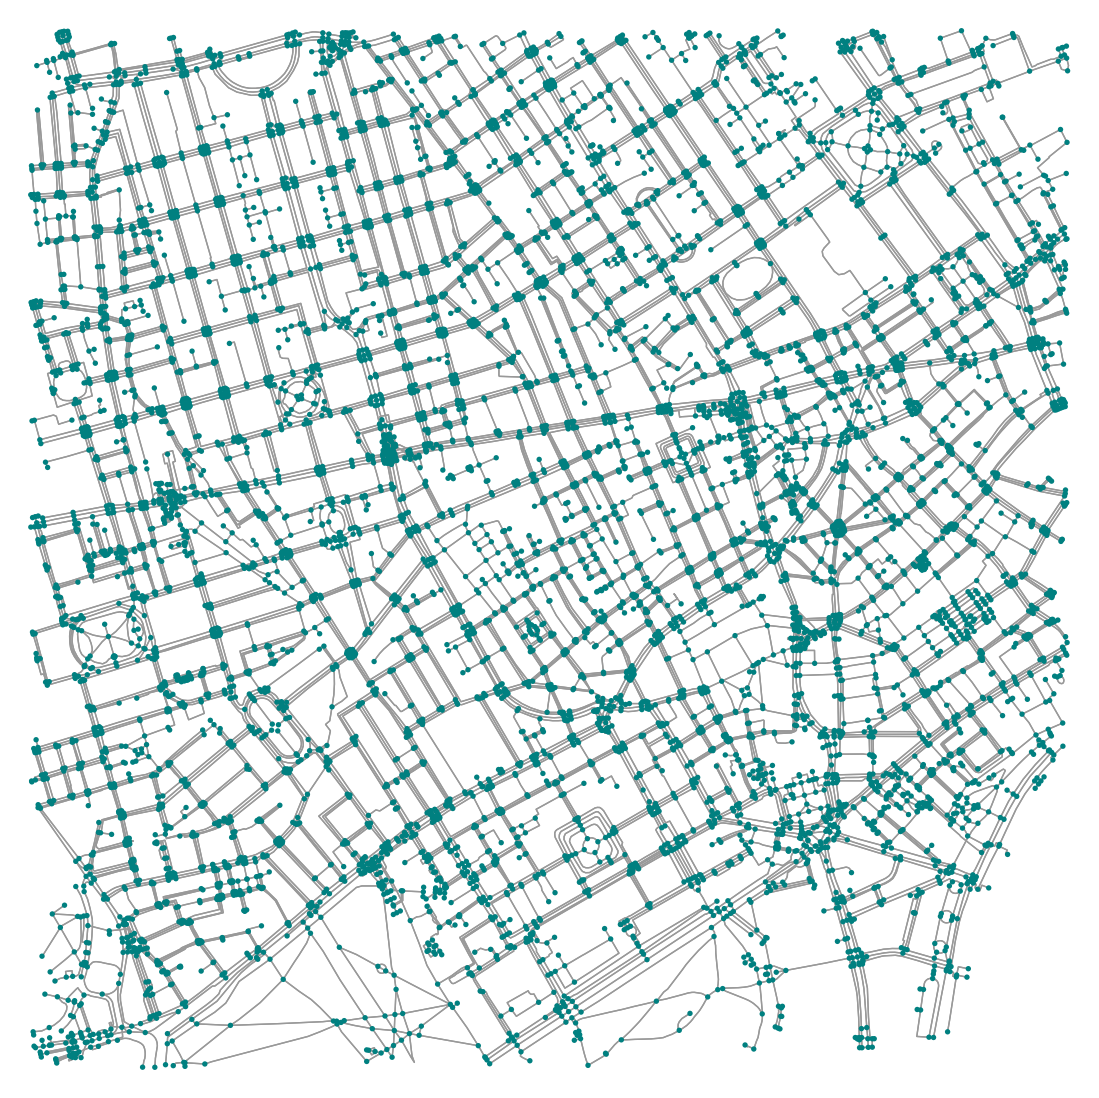

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# download the street network
G = ox.graph_from_point(BROAD_STREET_PUMP_COORDINATES, \
                        dist=1200, network_type=network_type)
fig, ax = ox.plot_graph(G, figsize=(14,14), bgcolor='white', node_color='teal')

Let's also generate a geodataframe from the OSMNx graph, `G`, but filter for nodes. If either `nodes` or `edges` are `True`, the resulting object is a geodataframe. If both `nodes` and `edges`are `True`, the resulting object is a tuple.

Obtain the OSM ID of the OSMNx node nearest to the Broad Street pump. Recall the `osmnx` code we used from the "Advanced 1" Cholera Case Study to calculate node to node distances.

In [7]:
import osmnx as ox

# BROAD_STREET_PUMP_COORDINATES = (lat, lon) format
lat, lon = BROAD_STREET_PUMP_COORDINATES

# assign the Broad Street pump osmnx node as the center node for the isochrones
center_node = ox.distance.nearest_nodes(G, lon, lat)

center_node


12442012125

### Load pump data

In [8]:
import pandas as pd

pumps_df = pd.read_csv('resources/pumps.csv')

pumps_df.head()

,FID,LON,LAT,Street
0,250,-0.136668,51.513341,Broadwick Street
1,251,-0.139586,51.513876,Kingly Street
2,252,-0.139671,51.514906,Ramillies Place
3,253,-0.131630,51.512354,Dean Street
4,254,-0.133594,51.512139,Rupert Street


Let's add a `PNODE` column to this Pandas dataframe. This column will represent the OSMNx node nearest to each pump.

In [11]:
import osmnx as ox

# Create a new column for storing nearest node IDs
pumps_df['PNODE'] = ''

# Loop through pump locations to find nearest node
for index, row in pumps_df.iterrows():
    lat = row['LAT']
    lon = row['LON']
    # Find nearest node to the pump location
    pump_node_id = ox.distance.nearest_nodes(G, lon, lat)
    # Store node ID in the DataFrame
    pumps_df.at[index, 'PNODE'] = pump_node_id

pumps_df


,FID,LON,LAT,Street,PNODE
0,250,-0.136668,51.513341,Broadwick Street,12442012125
1,251,-0.139586,51.513876,Kingly Street,21665926
2,252,-0.139671,51.514906,Ramillies Place,4684520654
3,253,-0.131630,51.512354,Dean Street,12437452130
4,254,-0.133594,51.512139,Rupert Street,12505260549
5,255,-0.135919,51.511542,Bridle Lane,11331120233
6,256,-0.133962,51.510019,Regent Street,1663004187
7,257,-0.138199,51.511295,Warwick Street,25257692


Let's save this dataframe.

In [12]:
pumps_df.to_pickle('outputs/pumps_df.pickle')

## Project `G` graph to Universal Transverse Mercator

In [13]:
# convert the nodes in the graph, G, to a Geopandas geodataframe
gdf_nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)

gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
99936,51.523627,-0.152799,4,NaN,NaN,POINT (-0.1528 51.52363)
99937,51.523018,-0.152024,3,NaN,NaN,POINT (-0.15202 51.52302)
99943,51.523551,-0.153244,1,NaN,NaN,POINT (-0.15324 51.52355)
101982,51.522879,-0.146259,3,NaN,NaN,POINT (-0.14626 51.52288)
101986,51.522284,-0.144392,4,NaN,NaN,POINT (-0.14439 51.52228)


The geodataframe, `gdf_nodes`, derived from G uses a Geographic Coordinate System (GCS), WGS84, and a long/lat projection. `WGS`, which stands for World Geodetic System, is a product of the [United States National Geospatial Agency (NGA)](https://www.nga.mil/ProductsServices/GeodesyandGeophysics/Pages/WorldGeodeticSystem.aspx). WGS84 is used in Open Street Map as well as in Global Positioning System (GPS) units.

Go to this [GeoPandas web page](https://geopandas.org/projections.html) to learn more about projections for GeoPandas GeoDataFrames.

In [14]:
wgs84_crs = gdf_nodes.crs

wgs84_crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We then project the map using Universal Transverse Mercator (UTM). Read more about UTM [here](https://gisgeography.com/utm-universal-transverse-mercator-projection/). UTM uses meters as unit of measure and also belongs under the WGS84 GCS. This makes it easier to measure distances and speed using the OSMNx package.

In [15]:
G = ox.project_graph(G)

After projecting to UTM, we can check whether the `.crs` value has changed.

In [16]:
gdf_nodes = ox.graph_to_gdfs(G, edges=False)

utm_crs = gdf_nodes.crs

utm_crs

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Displaying `gdf_nodes` shows the data under the `geometry` column have changed from degrees to meters.

In [17]:
gdf_nodes.head()

,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
99936,5.711900e+06,697511.507078,4,-0.152799,51.523627,NaN,NaN,POINT (697511.507 5711900.128)
12301792009,5.711899e+06,697507.169567,4,-0.152862,51.523617,crossing,NaN,POINT (697507.17 5711898.779)
2146383887,5.711901e+06,697519.851241,4,-0.152679,51.523630,NaN,NaN,POINT (697519.851 5711900.798)
12301792013,5.711849e+06,697528.166294,4,-0.152588,51.523159,crossing,NaN,POINT (697528.166 5711848.698)
12069796214,5.711931e+06,697500.637008,4,-0.152938,51.523908,crossing,NaN,POINT (697500.637 5711930.972)


Let's save the graph as a shapefile. The shapefile is created with the specified `filename` in the `folder` as named below.

In [18]:
ox.save_graph_shapefile(G, filepath='outputs/graph')

### Map projections

There is a 6-minute video below about map projections.

In [19]:
show_youtube("https://www.youtube.com/embed/kIID5FDi2JQ",900,600)

### Prepare to measure distances

Going back to the concept of nodes and edges in a graph, we add an edge attribute that allows us to compute time in minutes required to traverse each edge (street) given number of minutes.

In [20]:
travel_speed

4.5

In [21]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute


In [22]:
meters_per_minute

75.0

## Plot nodes you can reach on foot within each time interval

How far can you walk in 1, 5, 10, and 15 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

Recall we defined __trip time__ and __travel speed__ earlier (top of the notebook).
> `trip_times = [1, 5, 10, 15] #in minutes`  
> `travel_speed = 4.5 #walking speed in km/hour`

### Set isochrone fill colors

In [23]:
import networkx as nx

In [24]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='rainbow', start=0.3, return_hex=True)

# color the nodes according to isochrone then plot the street network
node_colors = {}

for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    
    for node in subgraph.nodes():
        node_colors[node] = color
        

Check this [networkx reference page](https://networkx.github.io/documentation/stable/_modules/networkx/generators/ego.html) to learn more about `nx.ego_graph()`.

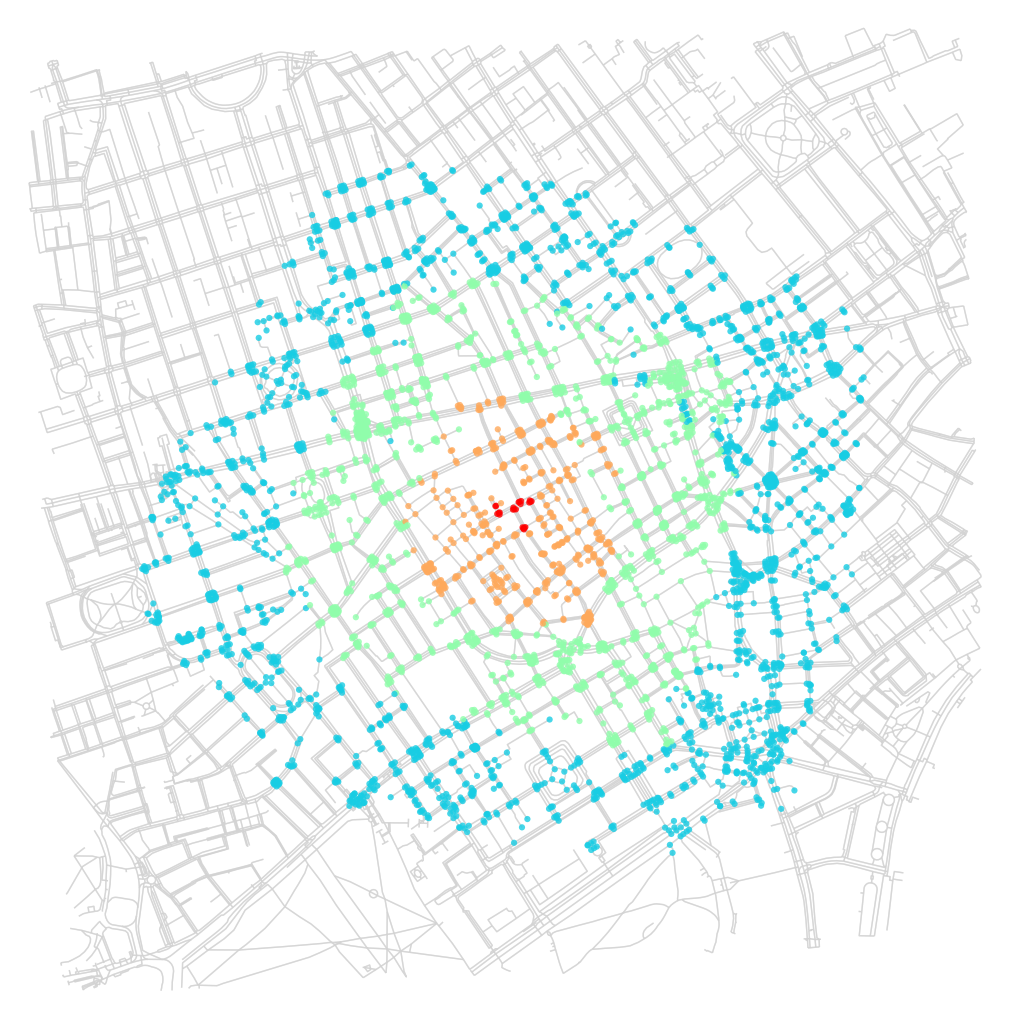

In [25]:
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]

fig, ax = ox.plot_graph(G, figsize=(13,13), node_color=nc,  edge_color='lightgray',\
                        bgcolor='white',\
                        node_size=ns, node_alpha=0.8, edge_alpha=0.7, node_zorder=2)


Note though the colors are suggestive, the graphic above does not clearly tell us the delineations of time-distance zones. 

How many colors do you see?

## Plot the time-distances as isochrones

To amplify cognition, the time-distance differences can be better visualized using isochrones. To draw the isochrones, we'll use Geopandas' convex hull function. 

Here is a short silent video about convex hulls (Quickhull method).

In [26]:
show_youtube("https://www.youtube.com/embed/3fQt5-JgNz0",900,600)

> The line below:
>  
> <font color='red'>`bounding_poly = \  
    gpd.GeoSeries(node_points).unary_union.convex_hull`</font>  
>  
> ...creates the bounding polygon for each time-distance zone.

In [27]:
from shapely.geometry import Point, LineString, Polygon

# create the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data \
                   in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)


Translating the `for` loop code above to natural language looks like this:

> <font color='blue'>For every trip time, starting from the biggest value (15 minutes):
1. Generate a subgraph from center node (the centroid obtained from previous code above)
2. Isolate all the points from subgraph
3. Generate the bounding polygons using convex hull method
4. Append the bounding polygons to a final set of isochrone polygons</font>

Printing `isochrone_polys` below shows it's a set of `Shapely` polygons. Learn more about `Shapely` [here](https://github.com/Toblerity/Shapely).

In [28]:
isochrone_polys

[<POLYGON ((699092.982 5709919.239, 698884.036 5709926.649, 698685.843 570994...>,
 <POLYGON ((698939.906 5710195.295, 698725.584 5710231.518, 698555.277 571026...>,
 <POLYGON ((698875.369 5710504.476, 698759.84 5710508.335, 698671.926 5710513...>,
 <POLYGON ((698711.192 5710750.092, 698642.671 5710790.024, 698637.987 571080...>]

We then add each polygon to a plot of the street network graph. The `PolygonPatch()` function is from the `descartes` package. The `descartes` package enables you to "use Shapely or GeoJSON-like geometric objects as matplotlib paths and patches". Learn more about `descartes` [here](https://pypi.org/project/descartes/).

Finally we can plot the isochrone polygons below.

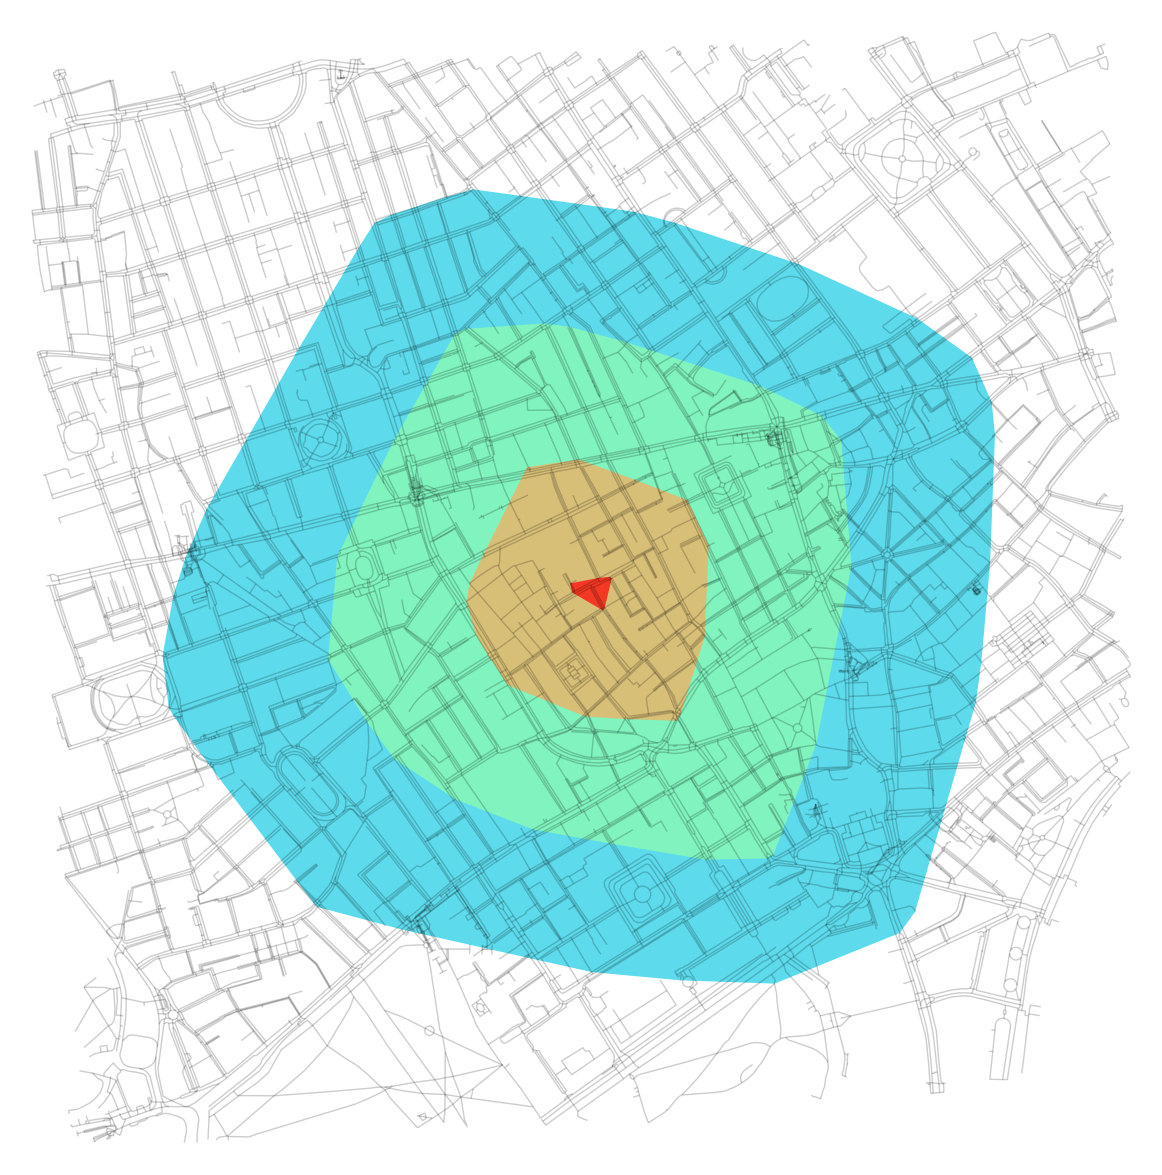

In [30]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

# Plot the network
fig, ax = ox.plot_graph(G, figsize=(15, 15), show=False, close=False, 
                        bgcolor='white', edge_color='k', edge_alpha=0.1, 
                        node_color='none')

# Convert isochrones to matplotlib patches
patches = []
facecolors = []

for polygon, fc in zip(isochrone_polys, iso_colors):
    if isinstance(polygon, Polygon):
        polygons = [polygon]
    elif isinstance(polygon, MultiPolygon):
        polygons = list(polygon.geoms)
    else:
        continue

    for poly in polygons:
        mpl_poly = MplPolygon(list(poly.exterior.coords), closed=True)
        patches.append(mpl_poly)
        facecolors.append(fc)

# Add patches to the plot
pc = PatchCollection(patches, facecolor=facecolors, edgecolor='none', alpha=0.7, zorder=-1)
ax.add_collection(pc)

plt.show()

## Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

We will use the Python function `make_iso_polys()` below 
to create isochrone polygons as buffers. 

Specifically, the code that creates the buffers are the following:

>```
n = nodes_gdf.buffer(node_buff).geometry
e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
```


In [32]:
%%writefile resources/make_iso_polys.py
import networkx as nx
from shapely.geometry import Point, LineString, Polygon
import geopandas as gpd

def make_iso_polys(G, center_node='25473293', trip_times=[1,5,10,15], \
                   edge_buff=25, node_buff=50, infill=False,\
                   crs='+proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'):

    isochrone_polys = []
    
    for trip_time in sorted(trip_times, reverse=True):
        
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
        node_points = []
        
        for node, data in subgraph.nodes(data=True):
            node_points.append(Point((data['x'], data['y'])))
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear 
        #    solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
        
    return isochrone_polys


Overwriting resources/make_iso_polys.py


We will then use this function in the code below and add the isochrone polygons to the a plot of the street network graph.

In [33]:
%run resources/make_iso_polys.py

<Figure size 640x480 with 0 Axes>

In [34]:
#%%time
#utm_crs='EPSG:32630'
#wgs84_crs='EPSG:4326'

isochrone_polys = make_iso_polys(G, center_node=center_node, trip_times=trip_times, 
                                 edge_buff=25, node_buff=0, infill=True, crs=utm_crs)

isochrone_polys

[<POLYGON ((697817.883 5710386.944, 697817.269 5710387.62, 697816.639 5710388...>,
 <POLYGON ((698192.025 5710478.82, 698191.953 5710478.795, 698190.834 5710478...>,
 <POLYGON ((698516.725 5710565.742, 698514.879 5710564.126, 698512.883 571056...>,
 <POLYGON ((698657.667 5710764.786, 698657.576 5710764.746, 698656.503 571076...>]

### Convert isochrone polygons to Geopandas geodataframes

Let's convert the Shapely polygons into Geopandas geodataframes. A quick plot and geodataframe display reveal UTM projection in meters.

In [35]:
poly_gdf_dict = {}

<Axes: >

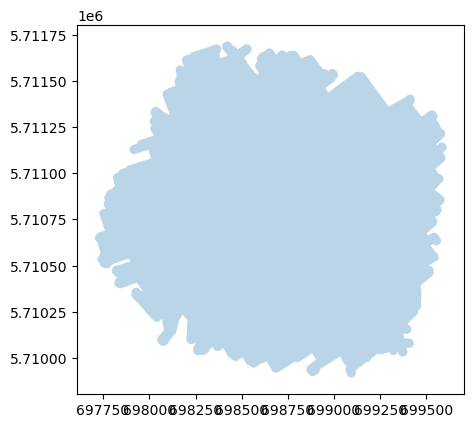

In [36]:
poly_gdf_dict[0] = gpd.GeoDataFrame(index=[0], geometry=[isochrone_polys[0]], crs=utm_crs)
poly_gdf_dict[0].plot(alpha=0.3)

In [37]:
poly_gdf_dict[0].crs

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
poly_gdf_dict[0]

,geometry
0,"POLYGON ((697817.883 5710386.944, 697817.269 5..."


Let's apply the same process to the other polygons and save these geodataframes for use in Notebook 6

<Axes: >

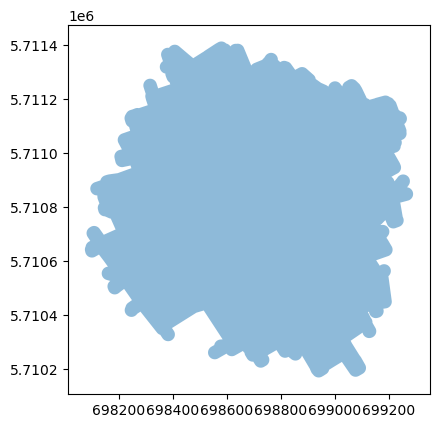

In [39]:
poly_gdf_dict[1] = gpd.GeoDataFrame(index=[0], geometry=[isochrone_polys[1]], crs=utm_crs)
poly_gdf_dict[1].plot(alpha=0.5)

In [40]:
poly_gdf_dict[1].crs = utm_crs

poly_gdf_dict[1].crs

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [41]:
poly_gdf_dict

{0:                                             geometry
 0  POLYGON ((697817.883 5710386.944, 697817.269 5...,
 1:                                             geometry
 0  POLYGON ((698192.025 5710478.82, 698191.953 57...}

<Axes: >

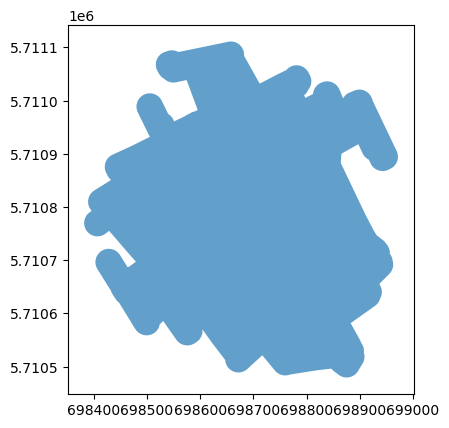

In [42]:
poly_gdf_dict[2] = gpd.GeoDataFrame(index=[0], geometry=[isochrone_polys[2]], crs=utm_crs)
poly_gdf_dict[2].plot(alpha=0.7)

In [43]:
poly_gdf_dict

{0:                                             geometry
 0  POLYGON ((697817.883 5710386.944, 697817.269 5...,
 1:                                             geometry
 0  POLYGON ((698192.025 5710478.82, 698191.953 57...,
 2:                                             geometry
 0  POLYGON ((698516.725 5710565.742, 698514.879 5...}

<Axes: >

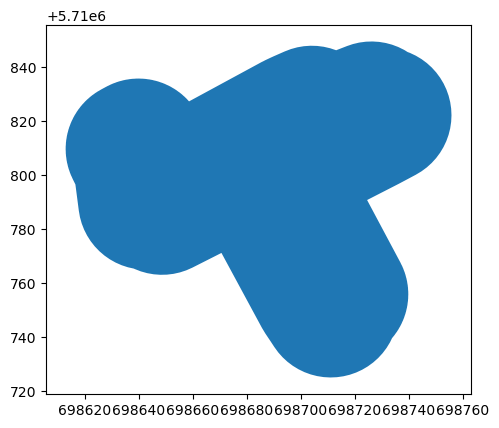

In [44]:
poly_gdf_dict[3] = gpd.GeoDataFrame(index=[0], geometry=[isochrone_polys[3]], crs=utm_crs)
poly_gdf_dict[3].plot(alpha=1)

In [45]:
poly_gdf_dict

{0:                                             geometry
 0  POLYGON ((697817.883 5710386.944, 697817.269 5...,
 1:                                             geometry
 0  POLYGON ((698192.025 5710478.82, 698191.953 57...,
 2:                                             geometry
 0  POLYGON ((698516.725 5710565.742, 698514.879 5...,
 3:                                             geometry
 0  POLYGON ((698657.667 5710764.786, 698657.576 5...}

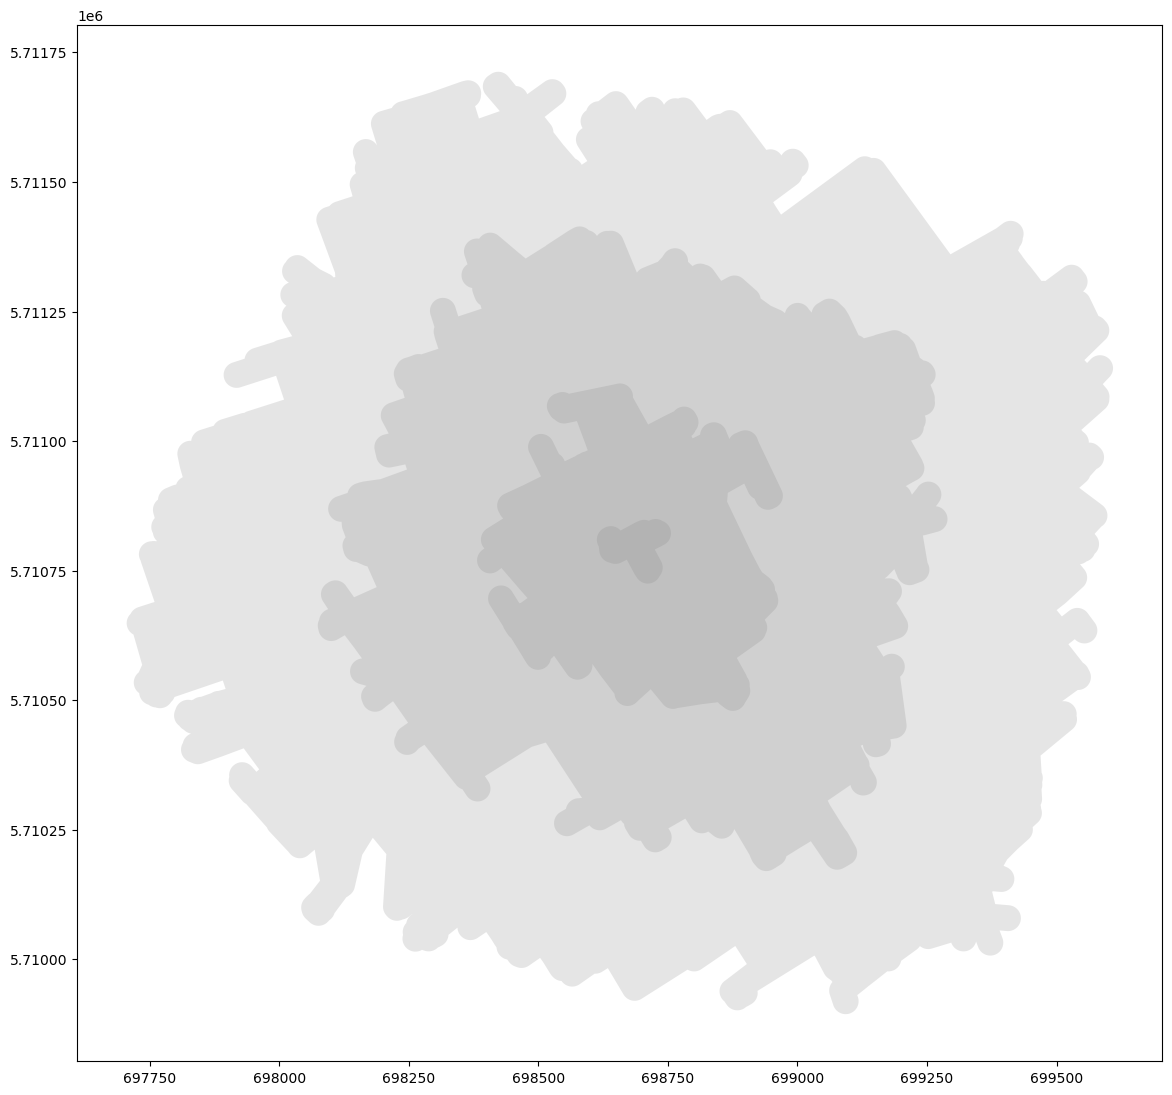

In [46]:
fig, ax = plt.subplots(figsize=(14,14))

for i in poly_gdf_dict:
    poly_gdf_dict[i].plot(ax=ax, color='grey',alpha=0.2)

## Combine isochrones with Cholera data (pumps and deaths)

### Load Cholera deaths data

In [47]:
import pandas as pd

deaths_df = pd.read_csv('resources/cholera_deaths.csv')

deaths_df.head()

,FID,DEATHS,LON,LAT
0,0,3,-0.137930,51.513418
1,1,2,-0.137883,51.513361
2,2,1,-0.137853,51.513317
3,3,1,-0.137812,51.513262
4,4,4,-0.137767,51.513204


### Project Cholera data to UTM (same as isochrone polygons)

In [48]:
utm_crs

<Projected CRS: EPSG:32630>
Name: WGS 84 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°W and 0°W, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Burkina Faso. Côte' Ivoire (Ivory Coast). Faroe Islands - offshore. France. Ghana. Gibraltar. Ireland - offshore Irish Sea. Mali. Mauritania. Morocco. Spain. United Kingdom (UK).
- bounds: (-6.0, 0.0, 0.0, 84.0)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
deaths_gdf = \
    gpd.GeoDataFrame(\
                     deaths_df, \
                     geometry=gpd.points_from_xy(deaths_df.LON, deaths_df.LAT),
                     crs=wgs84_crs).to_crs(utm_crs)

deaths_gdf

,FID,DEATHS,LON,LAT,geometry
0,0,3,-0.137930,51.513418,POINT (698587.212 5710805.302)
1,1,2,-0.137883,51.513361,POINT (698590.721 5710799.093)
2,2,1,-0.137853,51.513317,POINT (698592.993 5710794.282)
3,3,1,-0.137812,51.513262,POINT (698596.077 5710788.278)
4,4,4,-0.137767,51.513204,POINT (698599.451 5710781.952)
...,...,...,...,...,...
245,245,3,-0.137108,51.514526,POINT (698639.415 5710930.724)
246,246,2,-0.137065,51.514706,POINT (698641.614 5710950.854)
247,247,1,-0.138474,51.512311,POINT (698554.289 5710680.747)
248,248,1,-0.138123,51.511998,POINT (698580.001 5710646.9)


In [50]:
deaths_gdf.dtypes

FID            int64
DEATHS         int64
LON          float64
LAT          float64
geometry    geometry
dtype: object

In [51]:
pumps_gdf = \
    gpd.GeoDataFrame(\
                     pumps_df, \
                     geometry=gpd.points_from_xy(pumps_df.LON, pumps_df.LAT), \
                     crs=wgs84_crs).to_crs(utm_crs)

pumps_gdf

,FID,LON,LAT,Street,PNODE,geometry
0,250,-0.136668,51.513341,Broadwick Street,12442012125,POINT (698675.096 5710800.168)
1,251,-0.139586,51.513876,Kingly Street,21665926,POINT (698470.339 5710851.73)
2,252,-0.139671,51.514906,Ramillies Place,4684520654,POINT (698459.964 5710966.017)
3,253,-0.131630,51.512354,Dean Street,12437452130,POINT (699028.901 5710704.127)
4,254,-0.133594,51.512139,Rupert Street,12505260549,POINT (698893.586 5710674.881)
5,255,-0.135919,51.511542,Bridle Lane,11331120233,POINT (698734.889 5710602.186)
6,256,-0.133962,51.510019,Regent Street,1663004187,POINT (698877.293 5710438.174)
7,257,-0.138199,51.511295,Warwick Street,25257692,POINT (698577.787 5710568.532)


In [52]:
pumps_gdf['PNODE'] = pumps_gdf['PNODE'].astype(int)
pumps_gdf.dtypes

FID            int64
LON          float64
LAT          float64
Street        object
PNODE          int64
geometry    geometry
dtype: object

## Bring the plots together

In [53]:
def label_point(x, y, val, ax, fs):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+20, point['y']+10, str(point['val']), fontsize=fs)

In [55]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import MultiPolygon
from shapely.ops import unary_union

def make_iso_polys(G, center_node, trip_times, speed=4.5, edge_buff=25, node_buff=0, infill=True):
    """
    Generate isochrone polygons from a graph G.
    
    Parameters:
    - G: projected networkx graph with 'length' edge attributes
    - center_node: node to center isochrones on
    - trip_times: list of times (in minutes)
    - speed: travel speed in km per hour
    - edge_buff: buffer in meters around each reachable edge
    - node_buff: buffer in meters around isolated nodes
    - infill: whether to fill in holes within isochrone polygons

    Returns:
    - list of shapely polygons (from shortest to longest trip_time)
    """
    meters_per_minute = speed * 1000 / 60  # convert speed to meters/min
    isochrone_polys = []

    for trip_time in sorted(trip_times):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time * meters_per_minute, distance='length')

        # Generate GeoDataFrames for nodes and edges
        nodes_gdf = ox.graph_to_gdfs(subgraph, nodes=True, edges=False)
        edges_gdf = ox.graph_to_gdfs(subgraph, nodes=False, edges=True)

        # Buffer geometries
        edge_buffer = edges_gdf.buffer(edge_buff)
        node_buffer = nodes_gdf.buffer(node_buff)
        all_buffers = list(edge_buffer) + list(node_buffer)

        # Create unified polygon
        polygon = unary_union(all_buffers)

        if infill and isinstance(polygon, MultiPolygon):
            polygon = polygon.convex_hull

        isochrone_polys.append(polygon)

    return isochrone_polys

## Save GeoDataframes as SHP files

Let's transform all the geodataframes above to WGS84 CRS and save them as SHP files. We will check if coordinates have been converted to lat/lon before saving.

### Save isochrone polygons

In [56]:
poly_gdf_dict[0] = poly_gdf_dict[0].to_crs(wgs84_crs)

poly_gdf_dict[0]

,geometry
0,"POLYGON ((-0.14924 51.50993, -0.14925 51.50994..."


In [57]:
poly_gdf_dict[0].to_file(driver = 'ESRI Shapefile', filename="outputs/isopoly_15.shp")

In [58]:
poly_gdf_dict[1] = poly_gdf_dict[1].to_crs(wgs84_crs)

poly_gdf_dict[1]

,geometry
0,"POLYGON ((-0.1438 51.51062, -0.1438 51.51062, ..."


In [59]:
poly_gdf_dict[1].to_file(driver = 'ESRI Shapefile', filename="outputs/isopoly_10.shp")

In [60]:
poly_gdf_dict[2] = poly_gdf_dict[2].to_crs(wgs84_crs)

poly_gdf_dict[2]

,geometry
0,"POLYGON ((-0.13908 51.51129, -0.13911 51.51128..."


In [61]:
poly_gdf_dict[2].to_file(driver = 'ESRI Shapefile', filename="outputs/isopoly_5.shp")

In [62]:
poly_gdf_dict[3] = poly_gdf_dict[3].to_crs(wgs84_crs)

poly_gdf_dict[3]

,geometry
0,"POLYGON ((-0.13694 51.51303, -0.13694 51.51303..."


In [63]:
poly_gdf_dict[3].to_file(driver = 'ESRI Shapefile', filename="outputs/isopoly_1.shp")

### Save Cholera data

In [64]:
deaths_gdf = deaths_gdf.to_crs(wgs84_crs)

deaths_gdf

,FID,DEATHS,LON,LAT,geometry
0,0,3,-0.137930,51.513418,POINT (-0.13793 51.51342)
1,1,2,-0.137883,51.513361,POINT (-0.13788 51.51336)
2,2,1,-0.137853,51.513317,POINT (-0.13785 51.51332)
3,3,1,-0.137812,51.513262,POINT (-0.13781 51.51326)
4,4,4,-0.137767,51.513204,POINT (-0.13777 51.5132)
...,...,...,...,...,...
245,245,3,-0.137108,51.514526,POINT (-0.13711 51.51453)
246,246,2,-0.137065,51.514706,POINT (-0.13707 51.51471)
247,247,1,-0.138474,51.512311,POINT (-0.13847 51.51231)
248,248,1,-0.138123,51.511998,POINT (-0.13812 51.512)


In [65]:
deaths_gdf.to_file(driver = 'ESRI Shapefile', filename='outputs/deaths.shp')

In [66]:
pumps_gdf = pumps_gdf.to_crs(wgs84_crs)

pumps_gdf

,FID,LON,LAT,Street,PNODE,geometry
0,250,-0.136668,51.513341,Broadwick Street,12442012125,POINT (-0.13667 51.51334)
1,251,-0.139586,51.513876,Kingly Street,21665926,POINT (-0.13959 51.51388)
2,252,-0.139671,51.514906,Ramillies Place,4684520654,POINT (-0.13967 51.51491)
3,253,-0.131630,51.512354,Dean Street,12437452130,POINT (-0.13163 51.51235)
4,254,-0.133594,51.512139,Rupert Street,12505260549,POINT (-0.13359 51.51214)
5,255,-0.135919,51.511542,Bridle Lane,11331120233,POINT (-0.13592 51.51154)
6,256,-0.133962,51.510019,Regent Street,1663004187,POINT (-0.13396 51.51002)
7,257,-0.138199,51.511295,Warwick Street,25257692,POINT (-0.1382 51.51129)


In [67]:
pumps_gdf.to_file(driver = 'ESRI Shapefile', filename='outputs/pumps.shp')

Let's check how many SHP files we saved.

In [68]:
!ls -la outputs/*.shp

-rw-r--r-- 1 jovyan jovyan  7100 May 29 12:33 outputs/deaths.shp
-rw-r--r-- 1 jovyan jovyan 57212 May 29 12:33 outputs/isopoly_10.shp
-rw-r--r-- 1 jovyan jovyan 77468 May 29 12:33 outputs/isopoly_15.shp
-rw-r--r-- 1 jovyan jovyan  6684 May 29 12:33 outputs/isopoly_1.shp
-rw-r--r-- 1 jovyan jovyan 24396 May 29 12:33 outputs/isopoly_5.shp
-rw-r--r-- 1 jovyan jovyan   324 May 29 12:33 outputs/pumps.shp


## Additional things to do

This notebook is a starter. There are more steps to implement to fully realize the benefits of geospatial data analysis and visualization using OSMNx. You can use the same code above to plot isochrone polygons for the other pumps.

## References

1. Further Exploration #9: Isochrone Maps (Travel Time Maps). URL: http://datavizcatalogue.com/blog/isochrone-maps/
2. Boeing, G. Isochrone Maps with OSMnx + Python. URL: https://geoffboeing.com/2017/08/isochrone-maps-osmnx-python/
3. MapBox Isochrone Maps. URL: https://www.mapbox.com/bites/00156
4. https://en.wikipedia.org/wiki/Decimal_degrees
5. GeoPandas Version 0.80: Managing Projections. URL: https://geopandas.org/projections.html

*For case study suggestions for improvement, please contact Herman Tolentino, Jan MacGregor, James Tobias or Zhanar Haimovich.*